# Age Estimation for Customers
    
The retail supermarket "Bread-Salt" is implementing a computer vision system to process customer photos. Photo capture at the checkout area will help determine the age of customers in order to:
* Analyze purchases and suggest products that may interest customers in that age group.
* Control the cashiers' compliance when selling alcohol.

**Project Objective**: Build a model that can approximate a person's age based on their photo.

**Research Process**

The research will consist of 4 stages:

- 1. Exploratory data analysis of the photo dataset.
- 2. Data preparation for training.
- 3. Neural network training and evaluation of its quality.
- 4. Overall conclusion.

<img src="https://img.freepik.com/free-vector/camera-viewfinder-display_1284-46867.jpg" width="400" height="200" alt="Camera" />

# Data Description

The data is obtained from the **ChaLearn Looking at People** website (https://chalearnlap.cvc.uab.cat/dataset/26/description/).

We have a folder with all the images (/final_files) and a CSV file called labels.csv, which contains two columns: **`file_name`** and **`real_age`**.

## Exploratory Data Analysis

Load the necessary libraries and open the working file:

In [1]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 MB 1.2 MB/s eta 0:00:00m eta 0:00:010:00:04
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 1.7 MB/s eta 0:00:001.9 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 1.6 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 1.2 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 405.5 kB/s eta 0:00:0031m1.2 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.3/400.3 kB 980.2 kB/s eta 0:00:001.0 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 1.3 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 1.2 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 1.3 MB/s eta 0:00:000:00:010:00:01:01
     ━━━━━━━━━━━━━━━━


[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
# Library imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Parameter configuration

sns.set_style('darkgrid')

In [4]:
# Read the data file and save it in the variable df

df = pd.read_csv('./archive/labels.csv')

In [5]:
# Display the first 5 rows of the dataframe

df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


The data has been loaded correctly. Let's check the size of the dataset.

In [6]:
# Display general information about the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


* The dataset is relatively small, consisting of only 7591 images. If the dataset lacks diversity in terms of images, it may negatively affect the model training. There are no missing values.

Let's examine the distribution of ages in the `'real_age'` column.

In [7]:
# Display descriptive statistics of the column

df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Now to the age distribution plot.

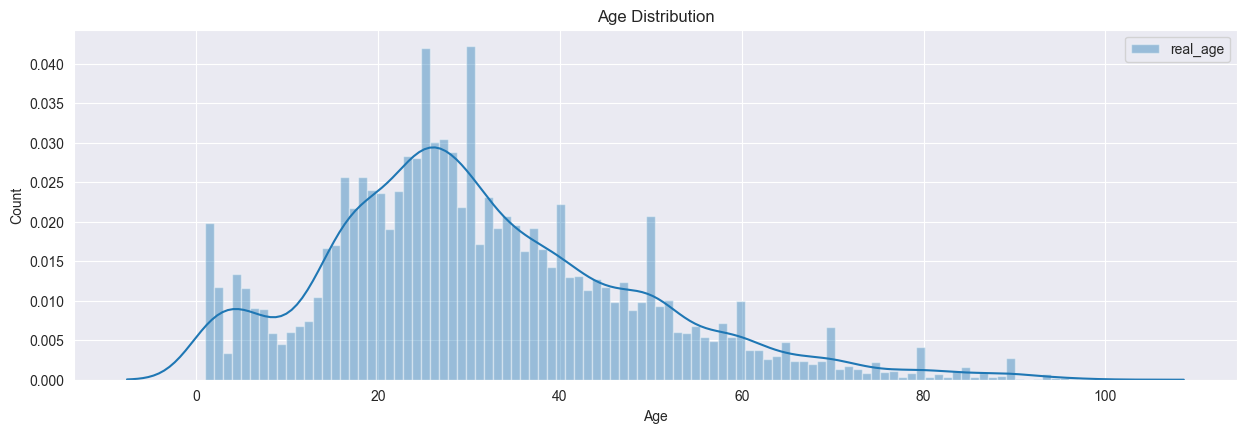

In [8]:
plt.figure(figsize=(15,10))
plt.subplot(211)
sns.distplot(df['real_age'], bins=100, label = "real_age")
plt.title('Age Distribution')
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend()
plt.show()

* The majority of people fall into the age range of 24 to 30 years, with an average age of 31. Age values above 80 can be considered outliers. The spikes every 10 years may be due to the rounding of the real age at the time of dataset annotation.

Next, I will display 15 photos to get a sense of the dataset structure.

In [9]:
# Scale brightness values to 255 and pass the argument to the ImageDataGenerator loader

train_datagen = ImageDataGenerator(rescale=1./255)

# Use the flow_from_directory() function to load data from the folder

train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=df,
                                                       directory='./archive/final_files/',
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(224, 224),
                                                       batch_size=16,
                                                       class_mode='raw',
                                                       seed=12345)

Found 7591 validated image filenames.


To obtain objects as "image-label" pairs, I will use the next() function.

In [10]:
features, target = next(train_datagen_flow)

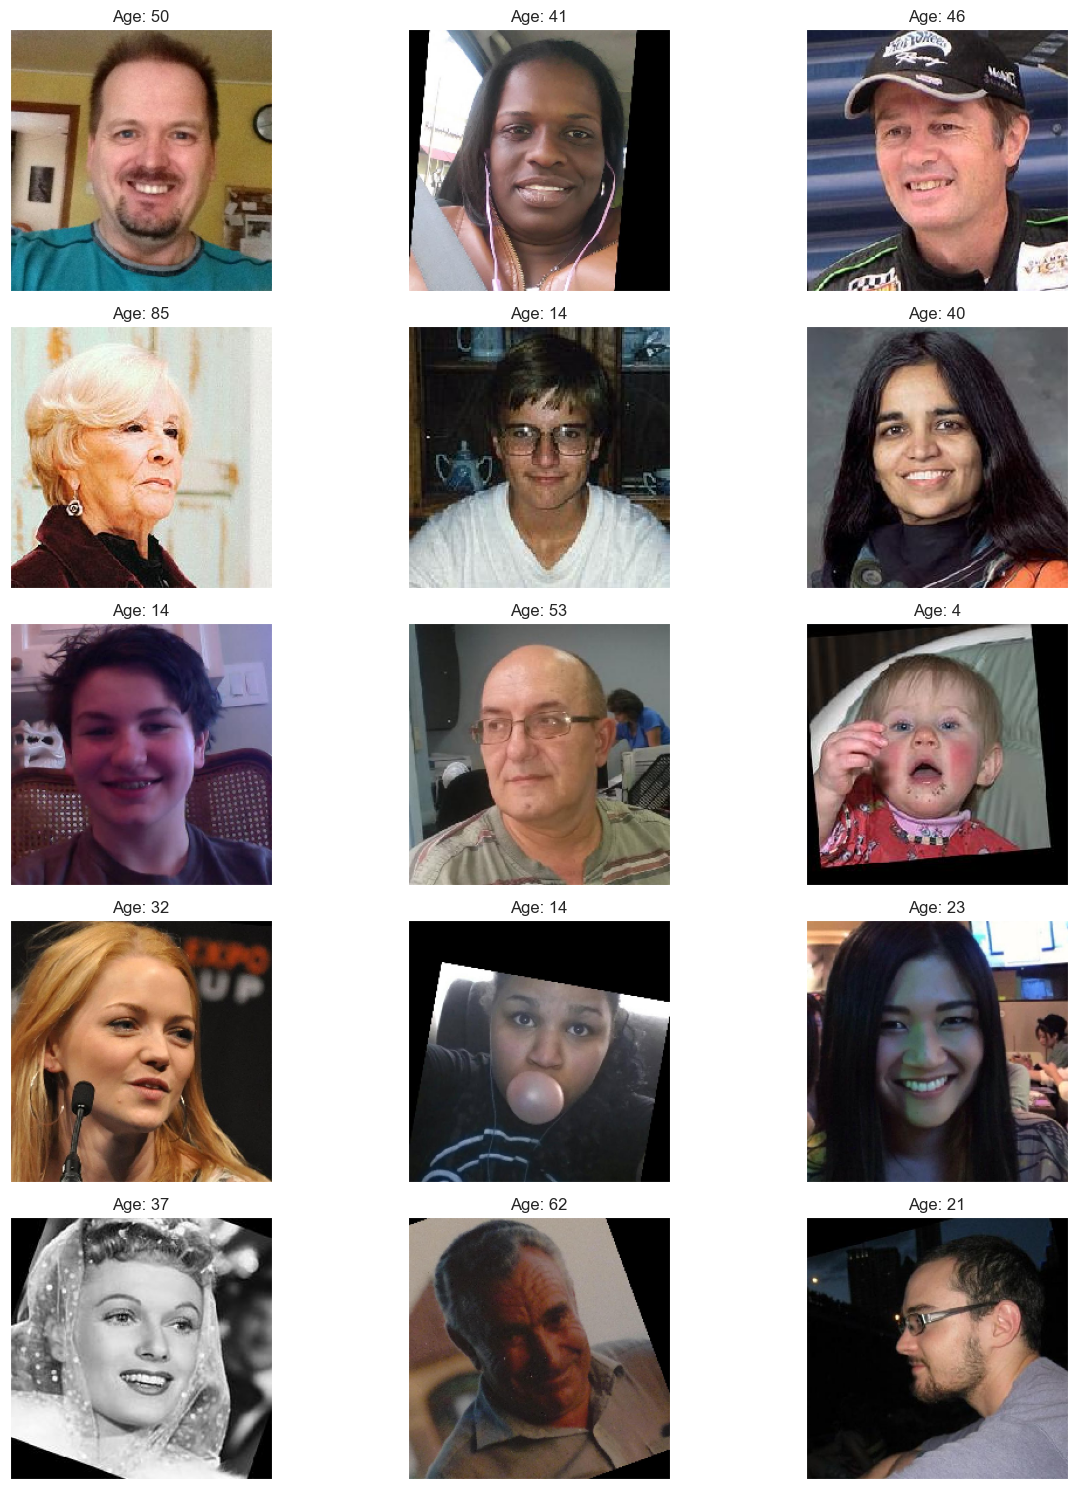

In [11]:
# Display 15 images

fig = plt.figure(figsize=(15,15))
for i in range(15):
    fig.add_subplot(5, 3, i+1)
    plt.imshow(features[i])
    
    # Remove axes and adjust spacing between images for compactness
    
    plt.title('Age: ' + str(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

* The presence of objects obstructing the face (hands, chewing gum, glasses, headwear), images taken from different angles, profiles, and black-and-white photos can lead to inaccurate age estimation. 

Based on these observations and to improve the model training, we will apply data **`augmentation`** techniques (image rotation, brightness and saturation adjustments, random cropping, or adding noise) to account for these factors and obtain more accurate age predictions using the available dataset.

## Model Training

The code in this section runs on a separate GPU trainer and is presented as text rather than code cells.

Data preparation for training.

```python
import numpy as np
import pandas as pd

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    df = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25, horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        directory=path + 'final_files/',
        dataframe=df,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow

def load_test(path):
    df = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        directory=path + 'final_files/',
        dataframe=df,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)    

    model = Sequential()

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              steps_per_epoch=steps_per_epoch,
              epochs=epochs,
              batch_size=batch_size,
              validation_steps=validation_steps,
              verbose=2)
    return model
```

Results of model training in the GPU trainer:

```
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/20
2023-03-01 09:20:33.713192: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-01 09:20:34.560438: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 79s - loss: 211.7177 - mae: 10.4767 - val_loss: 455.8247 - val_mae: 16.1602
Epoch 2/20
356/356 - 81s - loss: 83.1493 - mae: 6.9497 - val_loss: 121.7702 - val_mae: 8.6228
Epoch 3/20
356/356 - 75s - loss: 59.2392 - mae: 5.8707 - val_loss: 98.8655 - val_mae: 7.5411
Epoch 4/20
356/356 - 74s - loss: 44.5791 - mae: 5.0924 - val_loss: 79.4713 - val_mae: 6.5943
Epoch 5/20
356/356 - 76s - loss: 31.4626 - mae: 4.2646 - val_loss: 74.8320 - val_mae: 6.6696
Epoch 6/20
356/356 - 42s - loss: 23.2664 - mae: 3.7032 - val_loss: 68.4536 - val_mae: 6.3202
Epoch 7/20
356/356 - 56s - loss: 20.2468 - mae: 3.4393 - val_loss: 65.3093 - val_mae: 6.0946
Epoch 8/20
356/356 - 54s - loss: 16.1098 - mae: 3.0781 - val_loss: 67.3658 - val_mae: 6.3059
Epoch 9/20
356/356 - 45s - loss: 14.7585 - mae: 2.9354 - val_loss: 63.0351 - val_mae: 5.9721
Epoch 10/20
356/356 - 57s - loss: 12.8182 - mae: 2.7462 - val_loss: 71.7894 - val_mae: 6.3943
Epoch 11/20
356/356 - 55s - loss: 11.6749 - mae: 2.5879 - val_loss: 61.4232 - val_mae: 5.8518
Epoch 12/20
356/356 - 60s - loss: 11.2909 - mae: 2.5594 - val_loss: 79.7081 - val_mae: 6.9423
Epoch 13/20
356/356 - 54s - loss: 11.0576 - mae: 2.4877 - val_loss: 66.1342 - val_mae: 6.0895
Epoch 14/20
356/356 - 54s - loss: 11.3977 - mae: 2.5436 - val_loss: 63.2583 - val_mae: 6.0778
Epoch 15/20
356/356 - 55s - loss: 10.6801 - mae: 2.4881 - val_loss: 63.9768 - val_mae: 5.9986
Epoch 16/20
356/356 - 75s - loss: 9.9450 - mae: 2.4079 - val_loss: 61.0298 - val_mae: 5.7536
Epoch 17/20
356/356 - 78s - loss: 9.8064 - mae: 2.4015 - val_loss: 63.5006 - val_mae: 5.9666
Epoch 18/20
356/356 - 64s - loss: 9.5618 - mae: 2.3481 - val_loss: 63.9789 - val_mae: 5.9963
Epoch 19/20
356/356 - 79s - loss: 10.4601 - mae: 2.4544 - val_loss: 63.6812 - val_mae: 5.8787
Epoch 20/20
356/356 - 70s - loss: 10.0904 - mae: 2.3875 - val_loss: 70.6346 - val_mae: 6.4712
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 70.6346 - mae: 6.4712
Test MAE: 6.4712
```

The MAE values on the test set did not exceed 8, which meets the task requirements.

## Analysis of the Trained Model

The following steps were conducted during the research process:

✔️ Exploratory analysis of the photo dataset.
The dataset consisted of a total of 7591 images with no missing data. The age distribution showed the highest number of people in the age range of 24 to 30 years, with an average age of 31. The dataset also contained photos of children and older individuals. It was observed that the presence of objects obstructing the face, images taken from different angles, profiles, and black-and-white photos could lead to inaccurate age estimation.

✔️ Data preparation and neural network training using GPU. The model was based on ResNet50, and data augmentation was applied using the ImageDataGenerator. The Adam algorithm with a learning rate of 0.0001 was utilized. The mean absolute error (MAE) metric was used, and 20 epochs were specified.

Based on the analysis, the MAE values for the training and test sets were obtained: 2.3875 for training and 6.4712 for testing (indicating slight overfitting). This means that we have a model that can approximate a person's age based on their photo, with an error of approximately 6 years.